### Oganyan Robert

Если Вы не против, я некоторые вещи в домашнем задании переписал так, как хотел / как меня учили в ШАДе

# HW1: seq2seq nmt

**Homework Goals**

1. Get familiar with text data preparation
2. Learn to work with RNN
3. Train the model to translate `en-->ru`.



In [2]:
#!g1.1
%matplotlib inline
from collections import Counter
import unicodedata
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

from collections import Counter
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
import warnings
warnings.filterwarnings("ignore")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Naive way of texts representation:

0. Normalize spelling
1. Filter out all special characters
2. Split by spaces, do *naive tokenization*

In [3]:
#!g1.1
# Prepare data and look at it
# In addition to the dictionary, we are also interested in a set of characters
raw_alphabet = set()
alphabet = set()
def normalize(s):
    return "".join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


def preprocess(s):
    raw_alphabet.update(s)
    s = normalize(s.lower().strip())
    s = re.sub(r"[^a-zа-я?.,!]+", " ", s)
    s = re.sub(r"([.!?])", r" \1", s)
    alphabet.update(s)
    return s

pairs = []
with open('eng-rus.txt', 'r') as fin:
    for line in tqdm(fin.readlines()):
        pair = [preprocess(_) for _ in line.split('\t')]
        pairs.append(pair)
        
print("RAW alphabet {} symbols:".format(len(raw_alphabet)), 
      "".join(sorted(raw_alphabet)))
print("After preprocessing {} symbols: ".format(len(alphabet)), 
      "".join(sorted(alphabet)))
print("There are {} pairs".format(len(pairs)))
print(pairs[:5])


RAW alphabet 174 symbols: 
 !"$%&'()+,-./0123456789:;?@ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz «°º»ãçéêîïóöúǘЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяёׁ​–—―‘’… ‽₂€№
After preprocessing 62 symbols:   !,.?abcdefghijklmnopqrstuvwxyzабвгдежзиклмнопрстуфхцчшщъыьэюя
There are 336666 pairs
[['go .', 'иди .'], ['go .', 'идите .'], ['hi .', 'здравствуите .'], ['hi .', 'привет !'], ['hi .', 'хаи .']]


Each word will be assigned a number + we will need special tokens for the beginning and end of the sequence and for unknown words.
`<SOS>, <EOS>, <UNK>`

We have two languages, to work with each we need functions for translating from words to numbers and vice versa.

It is proposed to implement these functions as dictionaries. Allocate the first 4 numbers for special tokens

**(1 point)** Implement the dictionary building function, the function takes a list of strings (normalized sentences, can be splited by spaces) as input. Organize the dictionary in a reasonable way so that rare words can be thrown out if necessary.

In [4]:
#!g1.1

COMMON_TOKENS = ['PAD', 'SOS', 'EOS', 'UNK']

def build_vocabs(sents, max_size=1000):
    vocab = Counter()
    for sent in sents:
        vocab.update(sent.split())
        
    vocab = sorted(vocab.items(),  key = lambda item: item[1], reverse=True)
    len_of_vocab = max_size - len(COMMON_TOKENS)
    vocab = [word[0] for word in vocab[:len_of_vocab]]
    
    vocab = COMMON_TOKENS + vocab
    
    tok2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2tok = {idx: word for idx, word in enumerate(vocab)}
    
    return tok2idx, idx2tok


eng, rus = list(zip(*pairs))
rus2idx, idx2rus = build_vocabs(rus, max_size=10000)
eng2idx, idx2eng = build_vocabs(eng, max_size=5000)

In [5]:
#!g1.1
len(rus2idx), len(idx2rus), len(eng2idx), len(idx2eng)

(10000, 10000, 5000, 5000)

In [6]:
#!g1.1
def sentence2idx(s, tok2idx):
    tokens = preprocess(s).split(' ')
    unk = tok2idx['UNK']
    return [tok2idx['SOS']] + [tok2idx.get(_, unk) for _ in tokens] + [tok2idx['EOS']]


def idx2sentence(s, idx2tok):
    return " ".join(idx2tok[_] for _ in s)

# check the consistency of the transformations
x = sentence2idx('Привет мир!', rus2idx)
print(x)
print(idx2sentence(x, idx2rus))

x = sentence2idx('Hello world!', eng2idx)
print(x)
print(idx2sentence(x, idx2eng))

[1, 2539, 1264, 83, 2]
SOS привет мир ! EOS
[1, 1960, 439, 174, 2]
SOS hello world ! EOS


## Dealing with arbitrary length sequences in pytorch

We need to be able to generate batches of `[bs, 1, seq_len]` tensors.
But in our dataset, the samples are of different lengths:

- we could cut everything down to the minimum length
- padd to maximum length
- choose some average length

**(1 point)** Split the dataset on train and validate:

Ниже представлена версия датасета, где внутри делается паддинг к одинаковому размеру. Таким образом, мы можем прокликать ячейку с наивным даталоадером

In [7]:
#!g1.1
# make a dataset with encoded pairs:
class EngRusDataset(Dataset):
    def __init__(self, pairs, max_len=None, pad=eng2idx['PAD']):
        
        # same len for every sentence
        self.max_len = max_len or max(max(map(len, [x[0] for x in pairs])), max(map(len, [x[1] for x in pairs])))
        
        self.pairs = np.full([len(pairs), 2, self.max_len], pad, dtype=np.int64)
        for i in range(len(pairs)):
            eng_padded = pairs[i][0][:self.max_len]
            rus_padded = pairs[i][1][:self.max_len]
            self.pairs[i, 0, :len(eng_padded)] = eng_padded
            self.pairs[i, 1, :len(rus_padded)] = rus_padded
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, item):
        eng, rus = self.pairs[item]
        return dict(
            eng=eng,
            rus=rus,
        )

encoded = []
for eng, rus in tqdm(pairs):
    a = sentence2idx(eng, eng2idx)
    b = sentence2idx(rus, rus2idx)
    encoded.append((a, b))

    
train_data, val_data = train_test_split(encoded, train_size=0.8, random_state=42, shuffle=True)
trainset = EngRusDataset(train_data, max_len=15)
valset = EngRusDataset(val_data, max_len=15)

In [8]:
#!g1.1
trainloader = DataLoader(trainset, batch_size=8, shuffle=True)
it = iter(trainloader)
batch = next(it)['eng']
batch

tensor([[   1,    5,   22,   11,   36,    8,  377,    3,    4,    2,    0,    0,
            0,    0,    0],
        [   1,   19, 1132,   66,   44, 1546,    3,    4,    2,    0,    0,    0,
            0,    0,    0],
        [   1,   56,   39,   11,    7,   47,    3,    9,    2,    0,    0,    0,
            0,    0,    0],
        [   1,   26,   60,  163,  152,  207,  103, 1390,    3,    4,    2,    0,
            0,    0,    0],
        [   1,   19,  106,   11,   33, 1475,    3,    4,    2,    0,    0,    0,
            0,    0,    0],
        [   1,    6,   59,   85,   92,  740,   21,   44,  251,    3,    4,    2,
            0,    0,    0],
        [   1,   23,   38,    6,   15,  399,    3,    9,    2,    0,    0,    0,
            0,    0,    0],
        [   1,    7,   72,    8,  111,   12,  672,    3,    4,    2,    0,    0,
            0,    0,    0]])

Однако в беседе мы обсудили, что идеалогически здесь делать паддинг вроде как неверно, поэтому не будем менять код в датасете, будем делать паддинг в collate. Соответственно Датасет остается без изменений:

In [9]:
#!g1.1
from sklearn.model_selection import train_test_split
# make a dataset with encoded pairs:
class EngRusDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, item):
        eng, rus = self.pairs[item]
        return dict(
            eng=eng,
            rus=rus,
        )

encoded = []
for eng, rus in tqdm(pairs):
    a = sentence2idx(eng, eng2idx)
    b = sentence2idx(rus, rus2idx)
    encoded.append((a, b))

    
train_data, val_data = train_test_split(encoded, train_size=0.8, random_state=42, shuffle=True)
trainset = EngRusDataset(train_data)
valset = EngRusDataset(val_data)

Let's build a naive DataLoader and check how it makes batches:


In my case, the result was:
```
[tensor([1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([ 6,  7,  6, 15,  5,  6,  5, 62]),
 tensor([ 48,  34,  83,   7,  32, 221,  22,  43]),
 tensor([  5, 143,  37,  36, 129,  12,  11,  66]),
 tensor([  73, 1258,  279,    8,    6,  555,   41,   10]),
 tensor([  8, 140,   8, 628,  20,  96,  13, 270]),
 tensor([  47,    4,   15,   18,   55,  269,    6, 1287]),
 tensor([ 58,   2,  13, 140, 193, 140, 171, 140])]
```

What's weird here?
1. This is not a tensor, but a list of tensors. Accordingly, when iterating over zero dimension (`batch[i, :]`), we will get not an i-example, but i-tokens for all examples in the batch. This is not a problem, but different from the expected behavior.
2. Only one example ends with `<EOS>` (2), the others are cut off to match its length. And this is a problem.

We would like to padd all examples to the maximum length in the batch.
But at the stage of preparing the example (in the `__getitem__` function), we do not know the batch neighbors!
In order to change the batch merging logic, we need to write our own `collate_fn` function in the DataLoader constructor:

```
def collate_fn(samples):
    # samples -- list of dictionaries samples
    <...>
    return batch
```

**(1 point)** Write a `collate_fn` function that padds _correctly_ rus and eng sequences and merges them into batches, where `batch[i, :]` returns the tokens for the `i` example.

Expected output (for a sequence with left padding):

```
tensor([[   1,   10, 3429,  405,  113,  676,   10, 1031,  140,    4,    2],
        [   0,    1,   57,   18,   23,   19,   61,    7,  140,    4,    2],
        [   0,    0,    0,    1,   16,   17, 1131,  416,  140,    4,    2],
        [   0,    0,    0,    1,   13,  465,   75,  197,  140,    4,    2],
        [   0,    0,    0,    1,    6,  302,   13,  144,  140,    4,    2],
        [   0,    1,    6,   59,  205,  167,    8,   15,  140,    4,    2],
        [   0,    0,    0,    0,    1,    6,   14,  678,  140,    4,    2],
        [   0,    0,    1,    5,   29,   67,    6,   14,  140,    4,    2]])
```

Чтобы длина предложения в батче была одинаковой надо сделать паддинг. Буду добавлять PAD справа. Одинаковая длина предложений либо задается вручную, либо считается как максимальная длина закодированного предложения.

In [10]:
#!g1.1
max(map(len, [x[0] for x in train_data])), max(map(len, [x[1] for x in train_data])), max(map(len, [x[0] for x in val_data])), max(map(len, [x[1] for x in val_data]))

(49, 48, 50, 45)

Максимальные размеры слишком большие. Будем задавать фиксированную длину maxlen равную, например, 20.

*Заметка для будущего меня:* функтор получился немного костыльным. Я решил попробовать сделать через pad_to_sequence. Есть проблема: Если заданная максимальная длина больше, чем длина максимального по длине предложения, то он не будет паддить предложения к максимальной длине. Решение: добавить "мусорный" тензор заданной максимальной длины, а в конце, после паддингов, удалить его. Also Весь этот код можно переписать и сделать удобно через простой torch.full(), по аналогии первой версии датасета, но мне интересно было попробовать по-другому

In [11]:
#!g1.1
BATCH_SIZE = 8


class CollateFnEngRus():
    def __init__(self, max_len=None, pad=eng2idx['PAD']):
        self.pad = pad
        self.max_len = max_len
        
    def __call__(self, batch):
        data = dict(
            eng=list(),
            rus=list()
        )
        max_len = self.max_len or max(max(map(len, [x for x in batch['eng']])), max(map(len, [x for x in batch['rus']])))
        
        # Костыль, чтобы предложения паддились к максимальной длине
        data["eng"].append(torch.full((max_len,), fill_value=0))
        data["rus"].append(torch.full((max_len,), fill_value=0))
        
        for sentence in batch:
            eng, rus = torch.tensor(sentence['eng'], dtype=torch.int), torch.tensor(sentence['rus'], dtype=torch.int)
            eng[min(max_len - 1, len(eng) - 1)] = eng2idx['EOS']
            rus[min(max_len - 1, len(rus) - 1)] = rus2idx['EOS']
            data["eng"].append(eng[:max_len])
            data["rus"].append(rus[:max_len])
        
        data = {lang: pad_sequence(sentences, batch_first=True, padding_value=self.pad)[1:] for lang, sentences in data.items()}
        return data
    

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=CollateFnEngRus(max_len=15))
it = iter(trainloader)
next(it)['eng']

tensor([[   1,    6,  134,   11,  411,  119,    3,    4,    2,    0,    0,    0,
            0,    0,    0],
        [   1,   62,   34, 1555,    3,    4,    2,    0,    0,    0,    0,    0,
            0,    0,    0],
        [   1,    5,  140,  548,   31, 1290,  172,    3,    4,    2,    0,    0,
            0,    0,    0],
        [   1,    6,  165,   44, 2025,  423,  935,    3,    4,    2,    0,    0,
            0,    0,    0],
        [   1, 1098,  183,   12,  819,    3,    4,    2,    0,    0,    0,    0,
            0,    0,    0],
        [   1,   52, 1633,    5,  108,    6,   20, 3641,  137,  582,    5, 1432,
           19,   20,    2],
        [   1,   25,   98,   57,  244,   50,    8,  894, 1548,    3,    4,    2,
            0,    0,    0],
        [   1,    6,   20,  546,    3,    4,    2,    0,    0,    0,    0,    0,
            0,    0,    0]])

Now we have the correct data generator, and all we have to do is write the model (encoder and decoder).


### Encoder

The input tensor contains integers and has dimensions `[bs, seq_len]`,

We will pass them through the layer with embeddings and get the tensor `[bs, seq_len, dim]`. Now we have floating point numbers that can be fed to RNN layers as input.



GRU is an RNN with a specific structure:
<img src="https://habrastorage.org/webt/xt/_q/nj/xt_qnjgfjengqoqd4gizkq4j_wk.png">

In the picture, the yellow rectangles are the line layers with the corresponding activation functions.


`nn.RNN` allows you to create and use multi-layer one- and two-way layers as one layer.
All parameters must be specified during creation, and then simply applied during the forward pass.


The order of dimensions is a bit different from the usual in convolutional networks, this is due to the inability to parallel recurrent calculations effectively.


**batch_first=True**

Such an RNN layer expects two tensors as input:
  - input with sizes `[bs, seq_len, dim]`,
  - hidden_state with dimensions `[num_layers * num_directions, bs, hidden_size]`.
 
 
The output is two tensors:
- output `[bs, seq_len, dim]`,
- hidden `[num_layers * num_directions, bs, hidden]`.

We will apply RNN in two ways:
- to the entire sequence, to translate the entire phrase in one language into one vector (EncoderRNN)
- to one tensor and input token to generate a phrase in another language (DecoderRNN)


We will put the entire input sequence into a hidden state vector.

Немного переписал. Теперь Энкодер возвращает только последний скрытый слой, который идет к энкодеру на вход (по правде говоря, этот скрытый слой пропущен еще и через дополнительный линейный слой).

In [12]:
#!g1.1
class EncoderRNN(nn.Module):
    
    def __init__(self, vocab_size, hidden_size, emb_size=64):
        super().__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.num_layers = 1
        
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.rnn = nn.GRU(emb_size, hidden_size, batch_first=True, num_layers=self.num_layers)
        self.dec_start = nn.Linear(hidden_size, hidden_size)

        
    def forward(self, inp, hidden):
        batch_size = inp.shape[0]
        inp_emb = self.embeddings(inp)
        
        enc_seq, [last_state_but_not_really] = self.rnn(inp_emb, hidden)
        # enc_seq: [batch, len_of_sequence, hid_size], last_state: [batch, hid_size]
        
        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = ((inp != eng2idx['EOS']) & (inp != eng2idx['PAD'])).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 2)
        last_state = enc_seq[torch.arange(batch_size), lengths]
        # ^-- shape: [batch_size, hid_size]
        
        dec_start = self.dec_start(last_state)
        return [dec_start]
    
    def init_hidden(self, batch_size=1, device=None):
        # be aware about dimension! https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

In [13]:
#!g1.1
enc = EncoderRNN(vocab_size=len(eng2idx), hidden_size=256, emb_size=256)
x = next(it)['eng']
print(x.shape)
hidden = enc.init_hidden(8)
hidden_to_dec = enc(x, hidden)
print(hidden_to_dec[0].shape)

torch.Size([8, 15])
torch.Size([8, 256])


We want the decoder to generate a translation for us -- a sequence of tokens from another language, using the encoder's hidden state vector.

To do this, we will supply hidden and `<SOS>`token to the input.
At each step, the decoder will return hidden and output vector.
Output vector is the probability distribution for the next token (respectively, it has the size of the output language dictionary).

Декодер принимает батч предложений, пускает их по слову через GruCell, скрытый слой подается еще раз в GRU, а также он, пропущенный через линейный слой, возвращается нам в качестве логитов. В классе DecoderRNN написан функционал для обучения, но не предсказания.

In [14]:
#!g1.1
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, emb_size=64):
        super().__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        
        self.embeddings = nn.Embedding(vocab_size, emb_size)      
        self.rnn = nn.GRUCell(emb_size, hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)
        
    def decode_step(self, prev_state, prev_tokens):
        prev_gru0_state = prev_state[0]
        
        prev_embs = self.embeddings(prev_tokens)
        next_gru0_state = self.rnn(prev_embs, prev_gru0_state)
        new_dec_state = [next_gru0_state]
        output_logits = self.out(next_gru0_state)
        
        return new_dec_state, output_logits
    
    
    def forward(self, initial_state, out_tokens):
        batch_size = out_tokens.shape[0]
        state = initial_state
        
        # initial logits: always predict SOS
        onehot_bos = F.one_hot(torch.full([batch_size], rus2idx['SOS'], dtype=torch.int64),
                               num_classes=self.vocab_size).to(device=device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        
        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits.to(device=device))
        return torch.stack(logits_sequence, dim=1)


In [15]:
#!g1.1
dec = DecoderRNN(len(rus2idx), 256, 256)

Let's get a tensor with tokens of size `[bs, seq_len]` from the data generator and try to iterate over seq_len to generate the next token.

In [16]:
#!g1.1
it = iter(trainloader)
batch = next(it) # get batch
batch, y = batch['rus'], batch['eng']
print(batch.shape, y.shape)
bs, seq_len = batch.shape
output = dec(hidden_to_dec, batch)
print(output.shape)


torch.Size([8, 15]) torch.Size([8, 15])
torch.Size([8, 15, 10000])


**(6 points)** Fill in a training part and train the encoder and decoder.

1. You need to write getting the next token (integer) from the distribution: a vector of size `len(rus2idx)`. Since we are working in batches, this should be a batchified operation. You have several options for how to do this:
 - take by argmax
 - sample from distribution (torch.multinomial)
 - during training, take tokens from ground truth (and this must be done at least sometimes so that the model converges).
 
2. You need to write a loss calculation. It is convenient to do this at each step: after the `<EOS>` occurs in the example, you do not need to count the loss for it (in the vectorized version, you can multiply the loss for `<PAD>`-tokens by zero - this is called masking). Loss is simply the sum of cross-entropy losses for each step.


Функция для предсказания seq2seq модели. 

In [123]:
#!g1.1
def predict(model, inp_lines,batch_size = BATCH_SIZE, max_len=100):
    encoder, decoder = model
    encoder.to(device)
    decoder.to(device)
    encoder.eval()
    decoder.eval()
    
    def decode_inference(initial_state, batch_size = batch_size, max_len=max_len):
        batch_size = len(initial_state[0])
        state = initial_state
        
        # We genrate SOS at first
        outputs = [torch.full([batch_size], rus2idx['SOS'], dtype=torch.int64, 
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = decoder.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1)) # Probably should do beam search instead
            all_states.append(state)
        
        return torch.stack(outputs, dim=1), all_states

    hid = encoder.init_hidden(batch_size).to(device=device)
    initial_state = encoder(inp_lines, hid)
    out_ids, states = decode_inference(initial_state, batch_size, max_len)
    return out_ids.cpu().numpy(), states

Качество полученной модели будем мерить с помощью метрики BLEU на валидации. Machine translation is commonly evaluated with BLEU score. This metric simply computes which fraction of predicted n-grams is actually present in the reference translation. It does so for n=1,2,3 and 4 and computes the geometric average with penalty if translation is shorter than reference.

In [73]:
#!g1.1
from nltk.translate.bleu_score import corpus_bleu

def compute_bleu(translations, actual):
    return corpus_bleu(
        [[idx2sentence(ref.detach().cpu().numpy(), idx2rus).split()] for ref in actual],
        [idx2sentence(trans, idx2rus).split() for trans in translations],
        smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

Маска при подсчете лосса

In [20]:
#!g1.1
def compute_mask(sentences, lang2idx):
    return sentences != lang2idx['PAD']

In [120]:
#!g1.1
from collections import defaultdict
from IPython.display import clear_output
from tqdm import trange

def train_test_model(model, optimizer, dataloader, val_loader, epoches_cnt = 5): 
    encoder, decoder = model
    encoder.to(device)
    decoder.to(device)
    
    encoder.train()
    decoder.train()
    logs = defaultdict(list)
    
    step = 0
    for _ in trange(epoches_cnt):
        for batch in tqdm(dataloader):
            rus = batch['rus'].to(device)
            eng = batch['eng'].to(device)

            # Computing loss:
            mask = compute_mask(rus, rus2idx) # [batch_size, out_len]
            targets_1hot = F.one_hot(rus, len(rus2idx)).to(torch.float32)
            
            cur_batch_size = batch['rus'].shape[0]
            encoder_hidden = encoder.init_hidden(cur_batch_size).to(device)
            
            hidden_to_dec = encoder(eng, encoder_hidden)
            
            
            logits_seq = decoder(hidden_to_dec, rus) # outputs of the model, [batch_size, out_len, num_tokens]
            logprobs_seq = nn.LogSoftmax(dim=-1)(logits_seq)
            
            logp_out = (logprobs_seq * targets_1hot).sum(dim=-1) # log-probabilities of correct outputs, [batch_size, out_len]
            # ^-- this will select the probability of the actual next token.

            lengths = mask.sum()

            # average cross-entropy over tokens where mask == True
            mask_loss = torch.sum(logp_out * mask)
            loss = - mask_loss / lengths

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            logs['loss'].append(loss.item())
            
            # Validation
            if step % 100 == 0:
                logs['bleu'].append((step, validate(model, val_loader)))
                encoder.train()
                decoder.train()

            step+=1            
    print('Last loss:', logs['loss'][-1])
    return logs

def validate(model, dataloader):
    with torch.no_grad():
        scores = []
        for batch in dataloader:
            
            y_true = batch['rus']
            y_pred, _ = predict(model, batch['eng'].to(device=device), batch_size = batch['eng'].shape[0], max_len=SEQ_LEN)
            scores.append(compute_bleu(y_pred, y_true))

        return np.mean(scores)

    
def plot_logs(logs):
    clear_output()
    plt.figure()
    plt.plot(logs['loss'], zorder=1)
    plt.title('Train Loss')
    plt.xlabel('steps')
    plt.grid()
    plt.show()
    
    
    plt.figure()
    plt.plot(*zip(*logs['bleu']), zorder=1)
    plt.title('Validation Bleu')
    plt.xlabel('steps')
    plt.grid()    
    plt.show()


In [118]:
#!g1.1
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 256
SEQ_LEN = 15
encoder = EncoderRNN(vocab_size=len(eng2idx), hidden_size=256, emb_size=256)
decoder = DecoderRNN(vocab_size=len(rus2idx), hidden_size=256, emb_size=256)

opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=5e-3)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=CollateFnEngRus(SEQ_LEN))
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=CollateFnEngRus(SEQ_LEN))
model = (encoder, decoder)


logs = train_test_model(model, opt, trainloader, valloader, epoches_cnt=2)

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [03:00<03:00, 180.79s/it]

100%|██████████| 2/2 [06:02<00:00, 181.06s/it]


Last loss: 0.9346079230308533


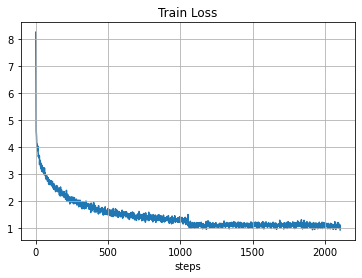

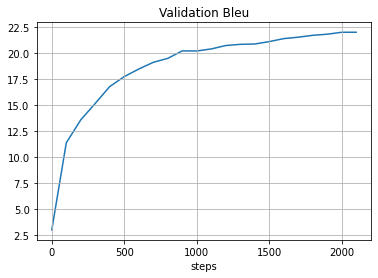

In [121]:
#!g1.1
plot_logs(logs)

In [139]:
#!g1.1
valloader2 = DataLoader(valset, batch_size=4, shuffle=True, collate_fn=CollateFnEngRus(SEQ_LEN))

encoder.eval()
decoder.eval()
model = (encoder, decoder)
with torch.no_grad():
    for batch in valloader2:
        y_true = batch['rus']
        y_pred, _ = predict(model, batch['eng'].to(device=device), batch_size = batch['eng'].shape[0], max_len=SEQ_LEN)

        for i in range(4):
            print('Source: ', idx2sentence(batch['eng'][i].detach().cpu().numpy(), idx2eng))
            print('Actual:', idx2sentence(batch['rus'][i].detach().cpu().numpy(), idx2rus))
            print('Predicted:', idx2sentence(y_pred[i], idx2rus))
            print('+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-')
        break

Source:  SOS do you miss your friends UNK ? EOS PAD PAD PAD PAD PAD PAD
Actual: SOS вы скучаете по своим друзьям UNK ? EOS PAD PAD PAD PAD PAD PAD
Predicted: SOS скучаешь по подругами UNK ? EOS UNK ? EOS UNK ? EOS UNK ? EOS
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Source:  SOS tom is still too young to understand that UNK . EOS PAD PAD PAD
Actual: SOS том еще слишком мал, чтобы это понять UNK . EOS PAD PAD PAD PAD
Predicted: SOS том все еще слишком молод, чтобы получать это UNK . EOS UNK . EOS UNK
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Source:  SOS forgive me if i have offended you UNK . EOS PAD PAD PAD PAD
Actual: SOS простите, если обидел UNK . EOS PAD PAD PAD PAD PAD PAD PAD PAD
Predicted: SOS прости, что я тебя беспокоюсь UNK . EOS UNK . EOS UNK . EOS UNK
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Source:  SOS i don t want to see anyone today UNK . EOS PAD PAD PAD
Actual: SOS я не хочу сегодня никого видеть UNK . EOS PAD PAD PAD PAD PAD
Predicted: SOS я не хочу сегодня кто нибудь увидеть UNK .

Мы сильно улучшили bleu и на глаз получили достаточно качественный перевод!

**(2 points)** Write a translation function with sampling from a distribution with temperature.

Хорошие модели машинного перевода (и языковые модели) должны обладать двумя свойствами: conherancy и diversity.
conherancy - сгенерированный текст должен иметь смысл. diversity - модель должна генерировать различные сэмплы. 

Добиться этого можно с помощью выбора не argmax логита, а выбрать случайный логит с взвешенными вероятностями. Однако у нас вполне может быть так, что один логит может быть сильно выше других, и поэтому он будет выбираться намного чаще других. Чтобы это исправить, делают сэмплинг с *температурой*, т.е делят логиты на какой-то гиперпараметр. Чем ниже температура, тем больше будет разница между максимальным логитом и оставшимися. Тем самым мы максимизируем критерий conherancy, но минимизируем diversity. Чем выше температура - тем более равномерными будут логиты. Теперь уже мы максимизируем diversity, но уменьшаем conherancy. В случае сэмплинга с температурой важно подобрать температуру так, чтобы соблюдался баланс этих двух критериев 

In [175]:
#!g1.1
encoder.eval()
decoder.eval()
encoder = encoder.to("cpu")
decoder = decoder.to("cpu")

def evaluate(sentence, T=1.0):
    encoded = sentence2idx(sentence, eng2idx)
    output = []
    print(encoded)
    print(sentence)
    bs = 10
    with torch.no_grad():
      
        z = torch.LongTensor(encoded).view(1, -1).repeat(bs, 1)
        
        def decode_inference(initial_state, batch_size, max_len):
            batch_size = len(initial_state[0])
            state = initial_state

            # We generate SOS at first
            outputs = [torch.full([batch_size], rus2idx['SOS'], dtype=torch.int64, 
                                  device='cpu')]
            all_states = [initial_state]

            for i in range(max_len):
                state, logits = decoder.decode_step(state, outputs[-1])
                logits = nn.Softmax(dim=-1)(logits / T)
                logits_np = logits.detach().cpu().numpy()
                logits = torch.full([batch_size], 0)
                
                for j in range(batch_size):
                    probs = logits_np[j]
                    idx = np.random.choice(len(probs), p=probs)
                    logits[j] = idx
                    
                outputs.append(logits)
                all_states.append(state)

            return torch.stack(outputs, dim=1), all_states

        hid = encoder.init_hidden(batch_size=bs).to(device='cpu')
        initial_state = encoder(z, hid)
        out_ids, states = decode_inference(initial_state, bs, 15)
        output = out_ids.cpu().numpy()
        
        for s in output:
            out = idx2sentence(s, idx2rus)
            print(out.replace('PAD', ""))
        

    
evaluate("What is going on?", T = 1.0)

[1, 23, 14, 63, 46, 9, 2]
What is going on?
SOS что происходит UNK ? EOS UNK ? EOS UNK ? EOS UNK ? EOS UNK
SOS что происходит UNK ? EOS EOS UNK ? EOS UNK ? EOS UNK ? EOS
SOS что происходит UNK ? EOS UNK ? EOS UNK ? EOS UNK ? EOS UNK
SOS чем сеичас UNK ? EOS UNK ? EOS UNK ? EOS UNK ? EOS UNK
SOS что будет потом UNK ? EOS UNK ? EOS UNK ? EOS UNK . EOS
SOS что происходит UNK ? EOS UNK ? EOS UNK ? EOS UNK ? EOS EOS
SOS что происходит UNK ? EOS UNK ? EOS UNK ? EOS UNK ? EOS ко
SOS что будет продолжаться UNK ? EOS UNK ? EOS UNK ? EOS EOS UNK ?
SOS что будете на UNK UNK ? EOS UNK ? EOS UNK ? EOS UNK ?
SOS что происходит UNK ? EOS UNK ? EOS UNK ? EOS UNK ? EOS UNK


Как видим при маленькой температуре мы получаем строго одно и то же

In [178]:
#!g1.1
evaluate("What is going on?", T = 0.5)

[1, 23, 14, 63, 46, 9, 2]
What is going on?
SOS что происходит UNK ? EOS UNK ? EOS UNK ? EOS UNK ? EOS UNK
SOS что происходит UNK ? EOS UNK ? EOS UNK ? EOS UNK ? EOS UNK
SOS что происходит UNK ? EOS UNK ? EOS UNK ? EOS UNK ? EOS UNK
SOS что происходит UNK ? EOS UNK ? EOS UNK ? EOS UNK ? EOS UNK
SOS что происходит UNK ? EOS UNK ? EOS UNK ? EOS UNK ? EOS UNK
SOS что происходит UNK ? EOS UNK ? EOS UNK ? EOS UNK ? EOS UNK
SOS что происходит UNK ? EOS UNK ? EOS UNK ? EOS UNK ? EOS UNK
SOS что происходит UNK ? EOS UNK ? EOS UNK ? EOS UNK ? EOS UNK
SOS что происходит UNK ? EOS UNK ? EOS UNK ? EOS UNK ? EOS UNK
SOS что происходит UNK ? EOS UNK ? EOS UNK ? EOS UNK ? EOS UNK


При большой температура - разнообразные сэмплы

In [179]:
#!g1.1
evaluate("What is going on?", T = 1.5)

[1, 23, 14, 63, 46, 9, 2]
What is going on?
SOS что происходит UNK ? EOS том UNK ? EOS EOS EOS UNK ? UNK ?
SOS что происходит UNK ? EOS UNK ? EOS UNK ? EOS вздохнул UNK ? EOS
SOS что ходить у вас UNK ? EOS UNK ? EOS UNK ? EOS UNK ?
SOS что вы собираетесь преступник UNK ? EOS моя UNK ? EOS дурак UNK ? EOS
SOS почему насчет тома UNK ? EOS преступник UNK ? EOS UNK ? EOS EOS UNK
SOS что происходит в одиночку UNK ? EOS UNK ? EOS UNK ? EOS отменить UNK
SOS что происходит UNK ? EOS UNK ? EOS UNK ? EOS EOS UNK ? EOS
SOS какои еду поидете UNK ? EOS UNK ? EOS UNK ? EOS UNK ? EOS
SOS что том тут UNK UNK ? EOS полотенце EOS EOS UNK ? EOS UNK ?
SOS что происходит UNK ? EOS UNK ? в EOS зоопарке UNK ? EOS UNK ?
